# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [69]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def get_dprinter(debug=True):
    def dprint(*args, **kwargs):
        if debug:
            print(*args, **kwargs)     
    return dprint

    
def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """
    dprint = get_dprinter(debug)
    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    dprint(f"--- K Matrix shape:{H_mat.shape} ---")
    dprint(H_mat)
    
    E_est = 0
    hist_population = np.zeros(n_steps)
    hist_shift = np.zeros(n_steps)
    hist_energy = np.zeros(n_steps)
    
    diag_H = np.diag(H_mat)    
    n_det = H_mat.shape[0]
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    # walkers = {ref_det_idx: init_n_walker}
    walkers = np.zeros(n_det, dtype=np.int32)
    walkers[ref_det_idx] = init_n_walker

    tqdm_pbar = tqdm(range(n_steps))
    for step in tqdm_pbar:
        # ----- Spawning Step -----
        # walkerのspawn先determinantをランダムに決める
        # spawn元インデックスを避けてspawn先インデックスを生成
        det_idx = np.arange(n_det)
        t_idx = np.random.randint(0, n_det-1, size=n_det)
        t_idx += (t_idx >= det_idx)

        # spawn確率を計算
        h_ij = H_mat[det_idx, t_idx]
        p_gen = 1/(n_det-1)
        prob_spawn = dt * abs(h_ij) / p_gen
        frac_prob_spawn, int_prob_spawn = np.modf(prob_spawn)

        # spawn確率の整数部分は確定spawn
        n_spawn = int_prob_spawn.astype(np.int32)
        # 小数部分は確率的にspawn
        n_spawn += np.random.binomial(abs(walkers), frac_prob_spawn)


        # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerをspawn
        signs = np.sign(walkers)
        signs[h_ij > 0] *= -1
        n_spawn *= signs
        new_walkers = np.zeros(n_det, dtype=np.int32)
        np.add.at(new_walkers, t_idx, n_spawn)

        # ----- Diagonal Step (Death/Cloning) -----
        prob_death = dt * (diag_H - shift)
        signs = np.sign(walkers)

        # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
        n_dc = np.random.binomial(abs(walkers), abs(prob_death))
        # prob_death>0ならwalkerを削除し、<0ならwalkerを複製
        n_dc[prob_death > 0] *= -1
        walkers = signs * (abs(walkers) + n_dc)

        # ----- Annihilation Step -----
        walkers += new_walkers

        # ---- Shift Update -----
        current_pop = np.sum(abs(walkers))
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift

        pre_pop = current_pop
        hist_shift[step] = shift
        hist_population[step] = current_pop

        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers[ref_det_idx]

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        s = row0 * walkers / num_ref
        E_proj = E_HF + np.sum(s[1:])

        # # E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # # 生成したコードでは論文にはない項を足していた
        # # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # # これを含めなければ近い値に収束するので、コメントアウトしておく
        # # E_proj += mol.energy_nuc()
        hist_energy[step] = E_proj

        if step % 1000 == 0:
            tqdm_pbar.set_postfix(n_walkwers=current_pop, shift=f"{shift:.5f}", E_proj=f"{E_proj:.6f}")
            dprint(f'{step} step')
            log_n_walkers(walkers, debug=debug)

    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均
    
    dprint('\n---- Walkers (result) ----')
    log_n_walkers(walkers, debug=debug)

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def log_n_walkers(walkers, debug=True, limit=10):
    dprint = get_dprinter(debug)
    idx = np.argsort(abs(walkers))[::-1]
    sorted_arr = walkers[idx]
    mask = sorted_arr != 0

    idx = idx[mask]
    sorted_arr = sorted_arr[mask]

    for i, v in zip(idx[:limit], sorted_arr[:limit]):
      dprint(f"  {v} walkers on {i}th determinant")

    if walkers.shape[0] > limit:
        dprint("  ... more")
    

def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)  

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()
    plt.grid(True)  

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    plt.grid(True)  
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- K Matrix shape:(4, 4) ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]


 15%|██████▎                                  | 4629/30000 [00:00<00:01, 23505.12it/s, E_proj=-1.136302, n_walkwers=113, shift=0.70000]

0 step
  3 walkers on 0th determinant
1000 step
  9 walkers on 0th determinant
  -1 walkers on 3th determinant
2000 step
  17 walkers on 0th determinant
  -1 walkers on 3th determinant
3000 step
  47 walkers on 0th determinant
  -2 walkers on 3th determinant
4000 step
  102 walkers on 0th determinant
  -11 walkers on 3th determinant


 15%|██████▎                                  | 4629/30000 [00:00<00:01, 23505.12it/s, E_proj=-1.137371, n_walkwers=235, shift=0.70000]

5000 step
  211 walkers on 0th determinant
  -24 walkers on 3th determinant


 31%|████████████▌                           | 9405/30000 [00:00<00:00, 23682.19it/s, E_proj=-1.136181, n_walkwers=8884, shift=0.70000]

6000 step
  431 walkers on 0th determinant
  -52 walkers on 3th determinant
7000 step
  874 walkers on 0th determinant
  -84 walkers on 3th determinant
8000 step
  1865 walkers on 0th determinant
  -214 walkers on 3th determinant
9000 step
  3943 walkers on 0th determinant
  -456 walkers on 3th determinant


 31%|████████████▏                          | 9405/30000 [00:00<00:00, 23682.19it/s, E_proj=-1.136432, n_walkwers=18360, shift=0.70000]

10000 step
  8024 walkers on 0th determinant
  -860 walkers on 3th determinant
11000 step
  16562 walkers on 0th determinant
  -1798 walkers on 3th determinant


 47%|█████████████████▍                   | 14142/30000 [00:00<00:00, 23579.06it/s, E_proj=-1.137479, n_walkwers=192054, shift=0.24349]

12000 step
  33970 walkers on 0th determinant
  -3813 walkers on 3th determinant
13000 step
  69804 walkers on 0th determinant
  -7546 walkers on 3th determinant
14000 step
  122677 walkers on 0th determinant
  -14454 walkers on 3th determinant
15000 step
  172348 walkers on 0th determinant
  -19706 walkers on 3th determinant


 55%|████████████████████▎                | 16501/30000 [00:00<00:00, 23537.66it/s, E_proj=-1.136729, n_walkwers=235207, shift=0.13433]

16000 step
  211860 walkers on 0th determinant
  -23347 walkers on 3th determinant


 71%|██████████████████████████▏          | 21202/30000 [00:00<00:00, 23335.35it/s, E_proj=-1.138221, n_walkwers=318038, shift=0.00026]

17000 step
  238572 walkers on 0th determinant
  -25843 walkers on 3th determinant
18000 step
  253909 walkers on 0th determinant
  -28097 walkers on 3th determinant
19000 step
  266604 walkers on 0th determinant
  -29049 walkers on 3th determinant
20000 step
  276788 walkers on 0th determinant
  -31707 walkers on 3th determinant
21000 step
  284360 walkers on 0th determinant
  -33678 walkers on 3th determinant


 86%|██████████████████████████████▉     | 25787/30000 [00:01<00:00, 21830.10it/s, E_proj=-1.136844, n_walkwers=335563, shift=-0.01989]

22000 step
  290776 walkers on 0th determinant
  -33388 walkers on 3th determinant
23000 step
  295110 walkers on 0th determinant
  -31912 walkers on 3th determinant
24000 step
  298802 walkers on 0th determinant
  -33812 walkers on 3th determinant
25000 step
  301860 walkers on 0th determinant
  -35217 walkers on 3th determinant
26000 step
  302082 walkers on 0th determinant
  -33481 walkers on 3th determinant


100%|████████████████████████████████████| 30000/30000 [00:01<00:00, 22949.01it/s, E_proj=-1.136754, n_walkwers=334536, shift=-0.03965]


27000 step
  303292 walkers on 0th determinant
  -33005 walkers on 3th determinant
28000 step
  303641 walkers on 0th determinant
  -37347 walkers on 3th determinant
29000 step
  301292 walkers on 0th determinant
  -33244 walkers on 3th determinant

---- Walkers (result) ----
  295983 walkers on 0th determinant
  -32616 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137322 ±  0.000549 Ha
Average shift: -0.013958 Ha => Energy: -1.1307170865805107


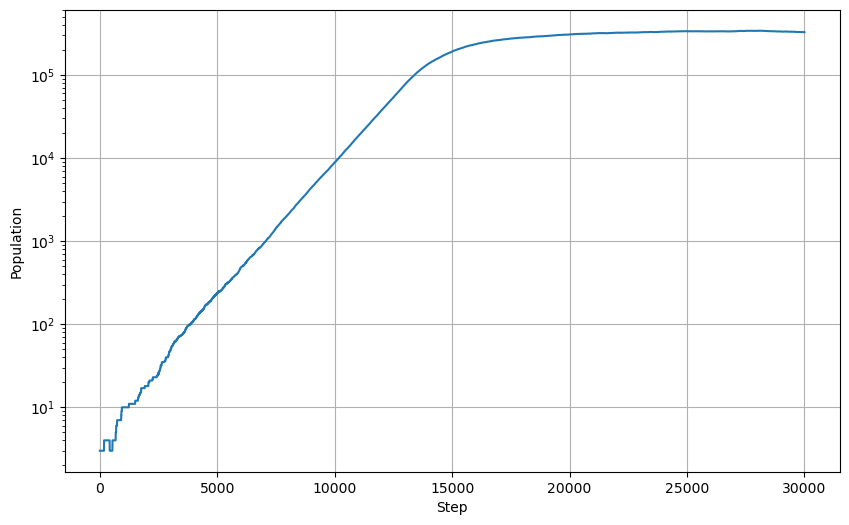

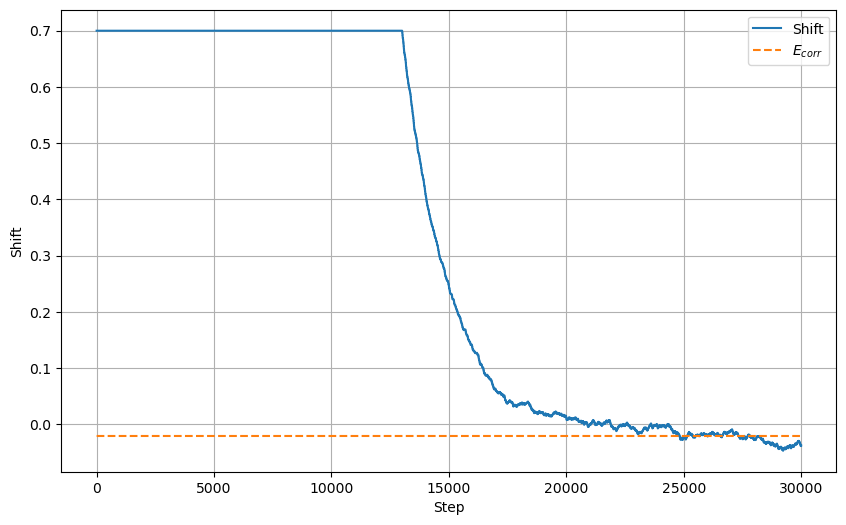

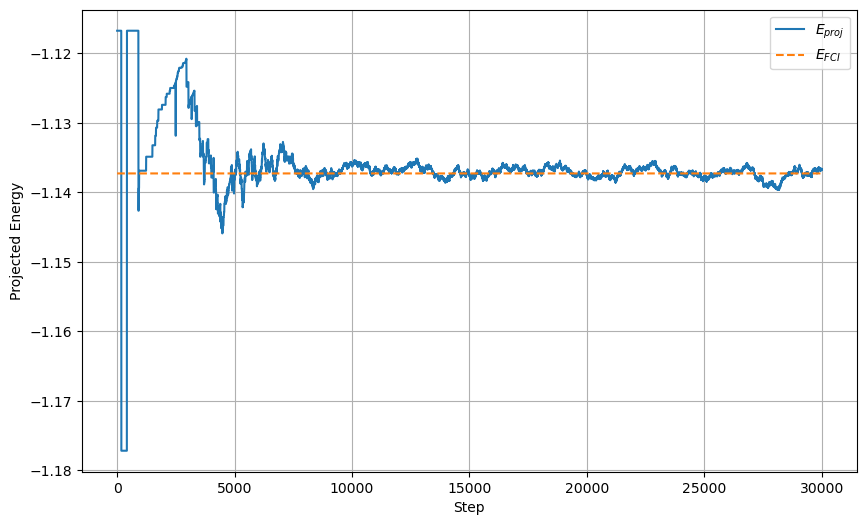

In [72]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)

E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=30000, n_prod=10000, step_starting_shift_upd=13000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-1.24591513e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -6.16148605e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -6.16130888e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -6.16148605e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.13702477e-01 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.56440

 14%|████████████▍                                                                             | 2763/20000 [00:00<00:00, 27617.38it/s]

Step 0: Walkers=1, Shift=0.80000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.80000, E_proj=-1.245915
  3 walkers on 0th determinant
Step 2000: Walkers=5, Shift=0.80000, E_proj=-1.245915
  5 walkers on 0th determinant
Step 3000: Walkers=31, Shift=0.80000, E_proj=-1.310750
  20 walkers on 0th determinant
  -1 walkers on 2th determinant
  -6 walkers on 4th determinant
  -1 walkers on 6th determinant
  -3 walkers on 8th determinant


 28%|████████████████████████▊                                                                 | 5525/20000 [00:00<00:01, 13919.89it/s]

Step 4000: Walkers=55, Shift=0.80000, E_proj=-1.285536
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -4 walkers on 6th determinant
  -3 walkers on 8th determinant
Step 5000: Walkers=118, Shift=0.80000, E_proj=-1.287798
  86 walkers on 0th determinant
  1 walkers on 2th determinant
  -15 walkers on 4th determinant
  -6 walkers on 6th determinant
  -10 walkers on 8th determinant
Step 6000: Walkers=242, Shift=0.80000, E_proj=-1.276843
  191 walkers on 0th determinant
  -2 walkers on 2th determinant
  -25 walkers on 4th determinant
  -8 walkers on 6th determinant
  -16 walkers on 8th determinant


 43%|██████████████████████████████████████▊                                                   | 8628/20000 [00:00<00:01, 11232.45it/s]

Step 7000: Walkers=507, Shift=0.80000, E_proj=-1.266403
  436 walkers on 0th determinant
  -2 walkers on 2th determinant
  -32 walkers on 4th determinant
  -7 walkers on 6th determinant
  -30 walkers on 8th determinant
Step 8000: Walkers=1173, Shift=0.80000, E_proj=-1.272471
  982 walkers on 0th determinant
  -1 walkers on 2th determinant
  -99 walkers on 4th determinant
  -9 walkers on 6th determinant
  -82 walkers on 8th determinant


 49%|████████████████████████████████████████████▎                                             | 9853/20000 [00:00<00:01, 10073.46it/s]

Step 9000: Walkers=2686, Shift=0.80000, E_proj=-1.272383
  2259 walkers on 0th determinant
  -3 walkers on 2th determinant
  -181 walkers on 4th determinant
  -9 walkers on 6th determinant
  -234 walkers on 8th determinant
Step 10000: Walkers=6175, Shift=0.80000, E_proj=-1.274244
  5152 walkers on 0th determinant
  2 walkers on 2th determinant
  -459 walkers on 4th determinant
  8 walkers on 6th determinant
  -554 walkers on 8th determinant


 59%|█████████████████████████████████████████████████████▏                                    | 11817/20000 [00:01<00:01, 6958.62it/s]

Step 11000: Walkers=12054, Shift=0.49802, E_proj=-1.274486
  10030 walkers on 0th determinant
  15 walkers on 2th determinant
  -917 walkers on 4th determinant
  20 walkers on 6th determinant
  -1072 walkers on 8th determinant


 63%|████████████████████████████████████████████████████████▌                                 | 12564/20000 [00:01<00:01, 5772.48it/s]

Step 12000: Walkers=18239, Shift=0.27219, E_proj=-1.274795
  15186 walkers on 0th determinant
  4 walkers on 2th determinant
  -1645 walkers on 4th determinant
  -5 walkers on 6th determinant
  -1399 walkers on 8th determinant


 66%|███████████████████████████████████████████████████████████▎                              | 13186/20000 [00:01<00:01, 4955.59it/s]

Step 13000: Walkers=22909, Shift=0.14186, E_proj=-1.273392
  19197 walkers on 0th determinant
  47 walkers on 2th determinant
  -1958 walkers on 4th determinant
  -4 walkers on 6th determinant
  -1703 walkers on 8th determinant


 71%|███████████████████████████████████████████████████████████████▊                          | 14169/20000 [00:02<00:01, 3878.91it/s]

Step 14000: Walkers=26592, Shift=0.08691, E_proj=-1.275099
  22038 walkers on 0th determinant
  43 walkers on 2th determinant
  -2114 walkers on 4th determinant
  47 walkers on 6th determinant
  -2350 walkers on 8th determinant


 76%|████████████████████████████████████████████████████████████████████▋                     | 15269/20000 [00:02<00:01, 3141.78it/s]

Step 15000: Walkers=29253, Shift=0.01651, E_proj=-1.276032
  24149 walkers on 0th determinant
  -11 walkers on 2th determinant
  -2618 walkers on 4th determinant
  45 walkers on 6th determinant
  -2430 walkers on 8th determinant


 82%|█████████████████████████████████████████████████████████████████████████▉                | 16432/20000 [00:02<00:01, 2752.30it/s]

Step 16000: Walkers=30119, Shift=-0.00320, E_proj=-1.275456
  24913 walkers on 0th determinant
  -38 walkers on 2th determinant
  -2778 walkers on 4th determinant
  60 walkers on 6th determinant
  -2330 walkers on 8th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 17500/20000 [00:03<00:00, 2634.89it/s]

Step 17000: Walkers=30185, Shift=-0.01282, E_proj=-1.272969
  25360 walkers on 0th determinant
  -51 walkers on 2th determinant
  -2484 walkers on 4th determinant
  12 walkers on 6th determinant
  -2278 walkers on 8th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 18305/20000 [00:03<00:00, 2531.17it/s]

Step 18000: Walkers=30865, Shift=-0.04630, E_proj=-1.275309
  25552 walkers on 0th determinant
  -64 walkers on 2th determinant
  -2456 walkers on 4th determinant
  36 walkers on 6th determinant
  -2757 walkers on 8th determinant


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 19343/20000 [00:04<00:00, 2567.80it/s]

Step 19000: Walkers=30621, Shift=-0.00677, E_proj=-1.273760
  25628 walkers on 0th determinant
  15 walkers on 2th determinant
  -2623 walkers on 4th determinant
  -25 walkers on 6th determinant
  -2330 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4701.77it/s]



---- Walkers (result) ----
25721 walkers on 0th determinant
6 walkers on 2th determinant
-2559 walkers on 4th determinant
-17 walkers on 6th determinant
-2392 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.274824 ±  0.000873 Ha
Average shift: 0.130721 Ha => Energy: -1.1151937009939108


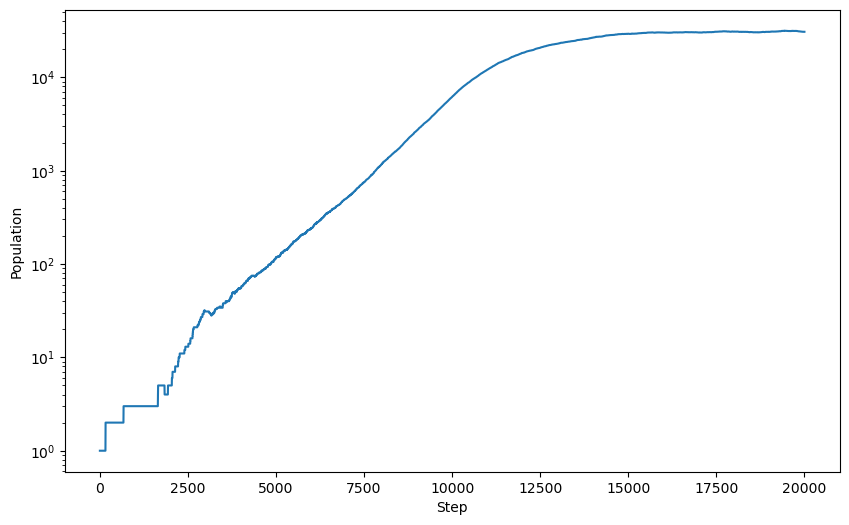

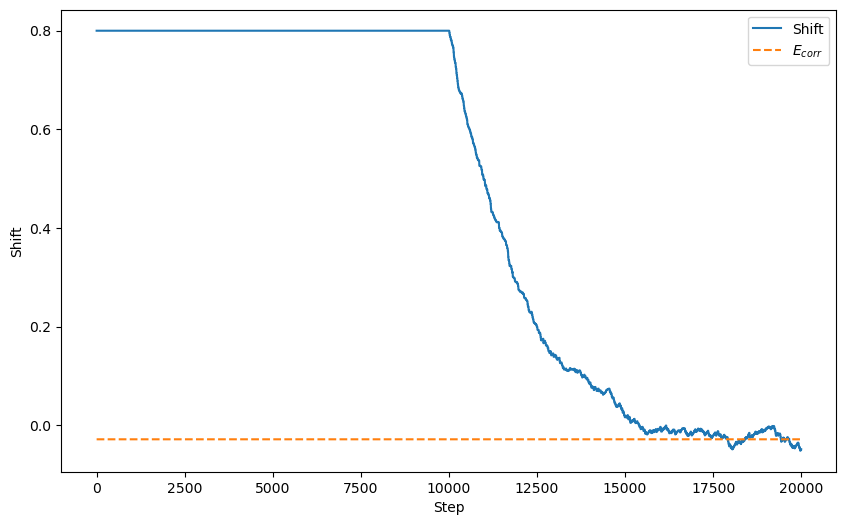

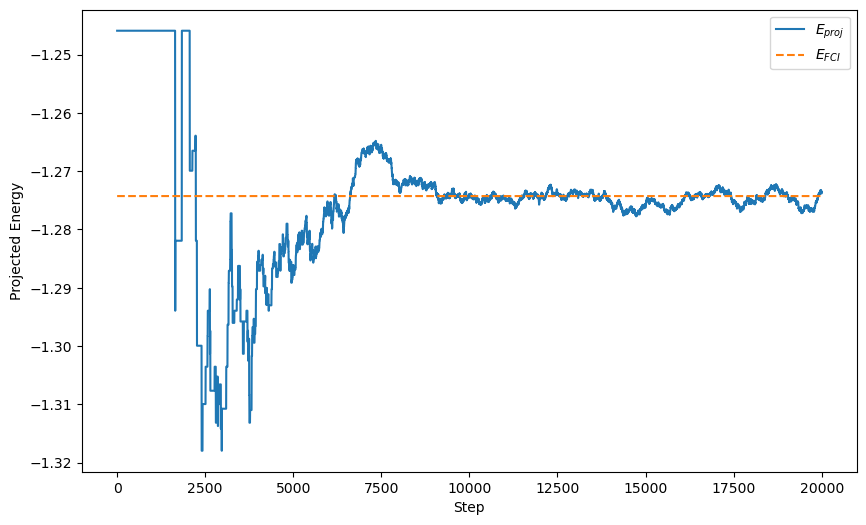

In [119]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ STO-3G
FCI行列は225x225

--- K Matrix shape:(225, 225) ---
[[ 3.55271368e-15  1.27143444e-08 -1.26871446e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871446e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.39953052e+00
   4.13894933e-18  2.35399868e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.13894933e-18
   6.44660276e+00  2.73717880e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.35399868e-18
   2.73717880e-18  6.48034104e+00]]


  1%|▎                                            | 412/50000 [00:00<00:12, 4101.01it/s, E_proj=-7.861865, n_walkwers=1, shift=0.70000]

  1 walkers on 0th determinant
  ... more

  1 walkers on 0th determinant
  ... more



  9%|███▋                                      | 4418/50000 [00:00<00:03, 13129.08it/s, E_proj=-7.861865, n_walkwers=25, shift=0.70000]

  2 walkers on 0th determinant
  ... more

  4 walkers on 0th determinant
  -1 walkers on 170th determinant
  ... more

  10 walkers on 0th determinant
  ... more

  23 walkers on 0th determinant
  -1 walkers on 141th determinant
  -1 walkers on 201th determinant
  ... more



 16%|██████▋                                  | 8110/50000 [00:00<00:02, 16245.17it/s, E_proj=-7.861762, n_walkwers=508, shift=0.70000]

  56 walkers on 0th determinant
  -2 walkers on 19th determinant
  -1 walkers on 5th determinant
  -1 walkers on 141th determinant
  1 walkers on 97th determinant
  -1 walkers on 167th determinant
  -1 walkers on 108th determinant
  ... more

  98 walkers on 0th determinant
  2 walkers on 63th determinant
  2 walkers on 28th determinant
  2 walkers on 195th determinant
  -1 walkers on 210th determinant
  -1 walkers on 51th determinant
  1 walkers on 62th determinant
  -1 walkers on 151th determinant
  -1 walkers on 150th determinant
  1 walkers on 180th determinant
  ... more

  217 walkers on 0th determinant
  -2 walkers on 51th determinant
  2 walkers on 46th determinant
  2 walkers on 158th determinant
  1 walkers on 58th determinant
  -1 walkers on 144th determinant
  1 walkers on 20th determinant
  -1 walkers on 150th determinant
  -1 walkers on 80th determinant
  1 walkers on 106th determinant
  ... more

  442 walkers on 0th determinant
  -8 walkers on 22th determinant
  8 walke

 27%|██████████▋                            | 13694/50000 [00:00<00:02, 17834.61it/s, E_proj=-7.862088, n_walkwers=7211, shift=0.70000]

  837 walkers on 0th determinant
  -28 walkers on 51th determinant
  -12 walkers on 126th determinant
  -7 walkers on 66th determinant
  -5 walkers on 25th determinant
  5 walkers on 213th determinant
  -5 walkers on 76th determinant
  -3 walkers on 123th determinant
  -3 walkers on 200th determinant
  3 walkers on 53th determinant
  ... more

  1584 walkers on 0th determinant
  -32 walkers on 51th determinant
  -17 walkers on 96th determinant
  -11 walkers on 151th determinant
  7 walkers on 57th determinant
  -6 walkers on 145th determinant
  -5 walkers on 130th determinant
  -5 walkers on 89th determinant
  -5 walkers on 3th determinant
  -4 walkers on 126th determinant
  ... more

  3213 walkers on 0th determinant
  -88 walkers on 87th determinant
  -31 walkers on 51th determinant
  -21 walkers on 3th determinant
  -19 walkers on 96th determinant
  18 walkers on 163th determinant
  15 walkers on 62th determinant
  15 walkers on 162th determinant
  -14 walkers on 26th determinant
  

 35%|████████████▊                        | 17281/50000 [00:01<00:01, 17889.14it/s, E_proj=-7.862055, n_walkwers=118608, shift=0.70000]

  13017 walkers on 0th determinant
  -400 walkers on 1th determinant
  -255 walkers on 31th determinant
  -226 walkers on 122th determinant
  -203 walkers on 205th determinant
  -150 walkers on 86th determinant
  -149 walkers on 10th determinant
  -128 walkers on 65th determinant
  -123 walkers on 131th determinant
  114 walkers on 91th determinant
  ... more

  26046 walkers on 0th determinant
  -698 walkers on 1th determinant
  -644 walkers on 3th determinant
  -555 walkers on 150th determinant
  -262 walkers on 134th determinant
  -234 walkers on 210th determinant
  -205 walkers on 54th determinant
  -165 walkers on 10th determinant
  159 walkers on 192th determinant
  -138 walkers on 48th determinant
  ... more

  52119 walkers on 0th determinant
  -1186 walkers on 1th determinant
  -1078 walkers on 3th determinant
  -687 walkers on 150th determinant
  412 walkers on 23th determinant
  373 walkers on 98th determinant
  368 walkers on 53th determinant
  325 walkers on 9th determinan

 42%|███████████████                     | 20840/50000 [00:01<00:01, 17496.73it/s, E_proj=-7.862178, n_walkwers=1793293, shift=0.51557]

  212392 walkers on 0th determinant
  -7513 walkers on 100th determinant
  -4673 walkers on 91th determinant
  -3770 walkers on 153th determinant
  -3385 walkers on 1th determinant
  -2709 walkers on 3th determinant
  -2421 walkers on 210th determinant
  1868 walkers on 15th determinant
  -1743 walkers on 9th determinant
  -1688 walkers on 50th determinant
  ... more

  427804 walkers on 0th determinant
  -7228 walkers on 100th determinant
  -5896 walkers on 1th determinant
  -5003 walkers on 91th determinant
  -4321 walkers on 3th determinant
  -4146 walkers on 70th determinant
  -3674 walkers on 153th determinant
  2208 walkers on 78th determinant
  -2042 walkers on 48th determinant
  -1997 walkers on 201th determinant
  ... more

  861844 walkers on 0th determinant
  -22713 walkers on 7th determinant
  -18220 walkers on 9th determinant
  -13374 walkers on 156th determinant
  -12328 walkers on 1th determinant
  -7129 walkers on 100th determinant
  6382 walkers on 90th determinant
  -

 49%|█████████████████▌                  | 24306/50000 [00:01<00:01, 16813.20it/s, E_proj=-7.861789, n_walkwers=4632893, shift=0.06941]

  2398633 walkers on 0th determinant
  -46133 walkers on 91th determinant
  -25573 walkers on 1th determinant
  22860 walkers on 15th determinant
  12050 walkers on 151th determinant
  -11379 walkers on 3th determinant
  -9874 walkers on 95th determinant
  -8344 walkers on 170th determinant
  -7984 walkers on 79th determinant
  -7201 walkers on 156th determinant
  ... more

  3073913 walkers on 0th determinant
  -48274 walkers on 151th determinant
  -30712 walkers on 91th determinant
  -26561 walkers on 1th determinant
  25414 walkers on 15th determinant
  -21630 walkers on 126th determinant
  -14572 walkers on 219th determinant
  13354 walkers on 159th determinant
  -12078 walkers on 3th determinant
  -10925 walkers on 75th determinant
  ... more

  3680906 walkers on 0th determinant
  -88449 walkers on 6th determinant
  -43053 walkers on 31th determinant
  -42758 walkers on 132th determinant
  31537 walkers on 15th determinant
  -27960 walkers on 151th determinant
  -27461 walkers on

 55%|███████████████████▉                | 27649/50000 [00:01<00:01, 16238.11it/s, E_proj=-7.864109, n_walkwers=8456620, shift=0.13463]

  4348894 walkers on 0th determinant
  -223782 walkers on 3th determinant
  -114745 walkers on 25th determinant
  -112458 walkers on 163th determinant
  -94265 walkers on 160th determinant
  -84057 walkers on 93th determinant
  -82017 walkers on 116th determinant
  -80327 walkers on 185th determinant
  -60312 walkers on 6th determinant
  -34984 walkers on 50th determinant
  ... more

  5035239 walkers on 0th determinant
  -235540 walkers on 3th determinant
  -110681 walkers on 26th determinant
  -81478 walkers on 25th determinant
  -61093 walkers on 6th determinant
  -51735 walkers on 93th determinant
  -38636 walkers on 160th determinant
  33725 walkers on 15th determinant
  31536 walkers on 204th determinant
  -28558 walkers on 158th determinant
  ... more

  5985026 walkers on 0th determinant
  -183803 walkers on 3th determinant
  -173736 walkers on 45th determinant
  -155441 walkers on 151th determinant
  -126524 walkers on 163th determinant
  -121765 walkers on 165th determinant
 

 65%|███████████████████████▎            | 32436/50000 [00:02<00:01, 15251.58it/s, E_proj=-7.862154, n_walkwers=1.06e+7, shift=0.10048]

  7935546 walkers on 0th determinant
  -169686 walkers on 93th determinant
  -162110 walkers on 3th determinant
  -147520 walkers on 45th determinant
  -82132 walkers on 160th determinant
  53198 walkers on 15th determinant
  -49923 walkers on 1th determinant
  -38983 walkers on 8th determinant
  -37479 walkers on 81th determinant
  -34157 walkers on 189th determinant
  ... more

  8494656 walkers on 0th determinant
  -220299 walkers on 40th determinant
  -140550 walkers on 3th determinant
  -131047 walkers on 45th determinant
  -96595 walkers on 93th determinant
  -96073 walkers on 106th determinant
  -80060 walkers on 96th determinant
  -75279 walkers on 145th determinant
  49252 walkers on 15th determinant
  -45742 walkers on 1th determinant
  ... more

  8946558 walkers on 0th determinant
  -234997 walkers on 161th determinant
  -124149 walkers on 3th determinant
  -111164 walkers on 45th determinant
  -100057 walkers on 88th determinant
  -95121 walkers on 199th determinant
  -853

 71%|█████████████████████████▌          | 35469/50000 [00:02<00:00, 14772.78it/s, E_proj=-7.861592, n_walkwers=1.62e+7, shift=0.09688]

  10134346 walkers on 0th determinant
  -115145 walkers on 3th determinant
  -98464 walkers on 45th determinant
  58092 walkers on 136th determinant
  50506 walkers on 66th determinant
  -48550 walkers on 155th determinant
  44391 walkers on 15th determinant
  -34840 walkers on 93th determinant
  -26957 walkers on 100th determinant
  -25341 walkers on 1th determinant
  ... more

  11716942 walkers on 0th determinant
  -234653 walkers on 75th determinant
  -133573 walkers on 177th determinant
  -107822 walkers on 3th determinant
  -93354 walkers on 45th determinant
  -80128 walkers on 120th determinant
  -63702 walkers on 40th determinant
  61424 walkers on 72th determinant
  -61090 walkers on 101th determinant
  51831 walkers on 16th determinant
  ... more

  13444744 walkers on 0th determinant
  -615817 walkers on 197th determinant
  -271353 walkers on 62th determinant
  -263875 walkers on 148th determinant
  -131958 walkers on 3th determinant
  108104 walkers on 196th determinant
  8

 77%|███████████████████████████▋        | 38417/50000 [00:02<00:00, 14648.04it/s, E_proj=-7.861982, n_walkwers=2.32e+7, shift=0.12188]

  15583814 walkers on 0th determinant
  -206542 walkers on 20th determinant
  -155682 walkers on 3th determinant
  121295 walkers on 18th determinant
  108421 walkers on 165th determinant
  93710 walkers on 82th determinant
  -92815 walkers on 6th determinant
  86074 walkers on 179th determinant
  -79656 walkers on 45th determinant
  72031 walkers on 15th determinant
  ... more

  18308451 walkers on 0th determinant
  -198088 walkers on 3th determinant
  166688 walkers on 96th determinant
  127080 walkers on 57th determinant
  91132 walkers on 195th determinant
  90770 walkers on 109th determinant
  -87374 walkers on 6th determinant
  82000 walkers on 33th determinant
  77590 walkers on 46th determinant
  77375 walkers on 18th determinant
  ... more

  20711860 walkers on 0th determinant
  -277154 walkers on 133th determinant
  -182807 walkers on 3th determinant
  153172 walkers on 21th determinant
  -136869 walkers on 8th determinant
  -115550 walkers on 56th determinant
  101153 walk

 83%|█████████████████████████████▊      | 41336/50000 [00:02<00:00, 14412.59it/s, E_proj=-7.862039, n_walkwers=3.11e+7, shift=0.09986]

  23410289 walkers on 0th determinant
  310311 walkers on 21th determinant
  -254542 walkers on 4th determinant
  -240084 walkers on 1th determinant
  -174900 walkers on 45th determinant
  -156546 walkers on 3th determinant
  147254 walkers on 48th determinant
  -128586 walkers on 6th determinant
  -98718 walkers on 115th determinant
  91181 walkers on 15th determinant
  ... more

  25723727 walkers on 0th determinant
  -226922 walkers on 1th determinant
  220414 walkers on 21th determinant
  163729 walkers on 55th determinant
  -144912 walkers on 3th determinant
  129915 walkers on 150th determinant
  -124420 walkers on 45th determinant
  -118538 walkers on 6th determinant
  96491 walkers on 48th determinant
  84166 walkers on 15th determinant
  ... more

  27951277 walkers on 0th determinant
  -209936 walkers on 1th determinant
  191489 walkers on 151th determinant
  -179746 walkers on 6th determinant
  -141380 walkers on 156th determinant
  -141057 walkers on 47th determinant
  -138

 88%|███████████████████████████████▊    | 44250/50000 [00:02<00:00, 14379.36it/s, E_proj=-7.861893, n_walkwers=3.44e+7, shift=0.01672]

  30221571 walkers on 0th determinant
  -893113 walkers on 45th determinant
  -545162 walkers on 91th determinant
  -397382 walkers on 46th determinant
  257027 walkers on 100th determinant
  192512 walkers on 5th determinant
  174515 walkers on 27th determinant
  -162437 walkers on 6th determinant
  -144510 walkers on 1th determinant
  128553 walkers on 182th determinant
  ... more

  31164193 walkers on 0th determinant
  -750841 walkers on 45th determinant
  -642039 walkers on 47th determinant
  -579269 walkers on 162th determinant
  -516427 walkers on 96th determinant
  -356920 walkers on 159th determinant
  -297943 walkers on 91th determinant
  -253345 walkers on 6th determinant
  -218890 walkers on 46th determinant
  154355 walkers on 93th determinant
  ... more

  30797523 walkers on 0th determinant
  -453373 walkers on 45th determinant
  -427185 walkers on 49th determinant
  -259695 walkers on 96th determinant
  -220855 walkers on 145th determinant
  -188582 walkers on 6th deter

 94%|█████████████████████████████████▉  | 47118/50000 [00:03<00:00, 14126.34it/s, E_proj=-7.862065, n_walkwers=3.88e+7, shift=0.09287]

  31193709 walkers on 0th determinant
  -889828 walkers on 25th determinant
  -866421 walkers on 91th determinant
  -441619 walkers on 28th determinant
  -432675 walkers on 59th determinant
  -379184 walkers on 45th determinant
  -267980 walkers on 76th determinant
  -224127 walkers on 68th determinant
  -191060 walkers on 189th determinant
  162122 walkers on 7th determinant
  ... more

  30293096 walkers on 0th determinant
  -431507 walkers on 25th determinant
  -313330 walkers on 91th determinant
  -298303 walkers on 45th determinant
  -243129 walkers on 16th determinant
  191671 walkers on 15th determinant
  -184489 walkers on 6th determinant
  -157287 walkers on 175th determinant
  -154396 walkers on 69th determinant
  -152225 walkers on 56th determinant
  ... more

  31828210 walkers on 0th determinant
  -762039 walkers on 46th determinant
  -709832 walkers on 48th determinant
  -641848 walkers on 4th determinant
  -454827 walkers on 53th determinant
  -293470 walkers on 78th det

100%|█████████████████████████████████████| 50000/50000 [00:03<00:00, 15160.67it/s, E_proj=-7.861635, n_walkwers=4.5e+7, shift=0.12917]


  35684165 walkers on 0th determinant
  -625606 walkers on 25th determinant
  -471822 walkers on 46th determinant
  -455475 walkers on 48th determinant
  -292520 walkers on 6th determinant
  -229654 walkers on 45th determinant
  -175076 walkers on 114th determinant
  165041 walkers on 16th determinant
  -160446 walkers on 101th determinant
  149473 walkers on 121th determinant
  ... more

  39556260 walkers on 0th determinant
  -815506 walkers on 91th determinant
  -365161 walkers on 34th determinant
  -341290 walkers on 25th determinant
  -309773 walkers on 48th determinant
  -276950 walkers on 46th determinant
  -262971 walkers on 6th determinant
  208377 walkers on 92th determinant
  195607 walkers on 102th determinant
  194434 walkers on 28th determinant
  ... more


---- Walkers (result) ----
  42065624 walkers on 0th determinant
  -663174 walkers on 91th determinant
  -420160 walkers on 72th determinant
  -413729 walkers on 129th determinant
  -389481 walkers on 99th determinant


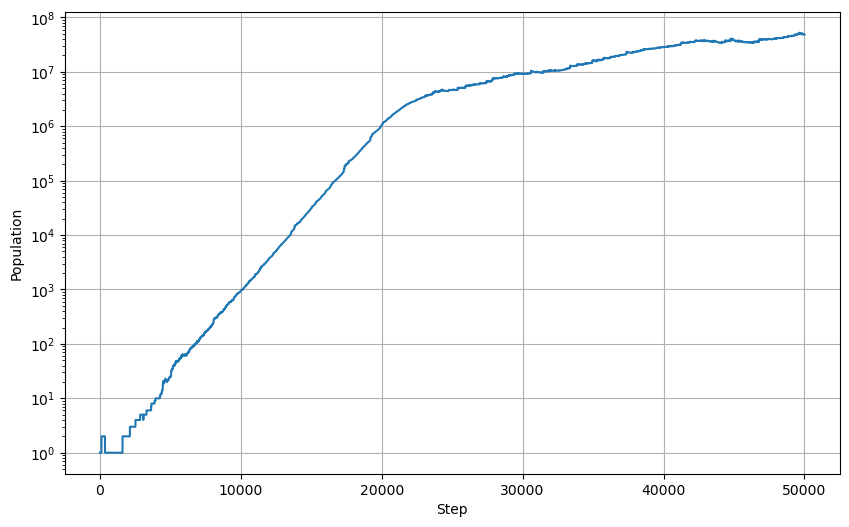

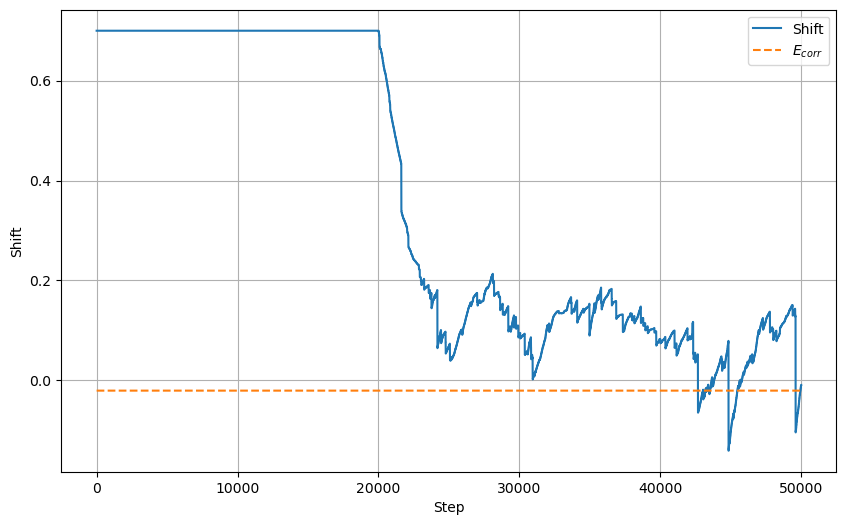

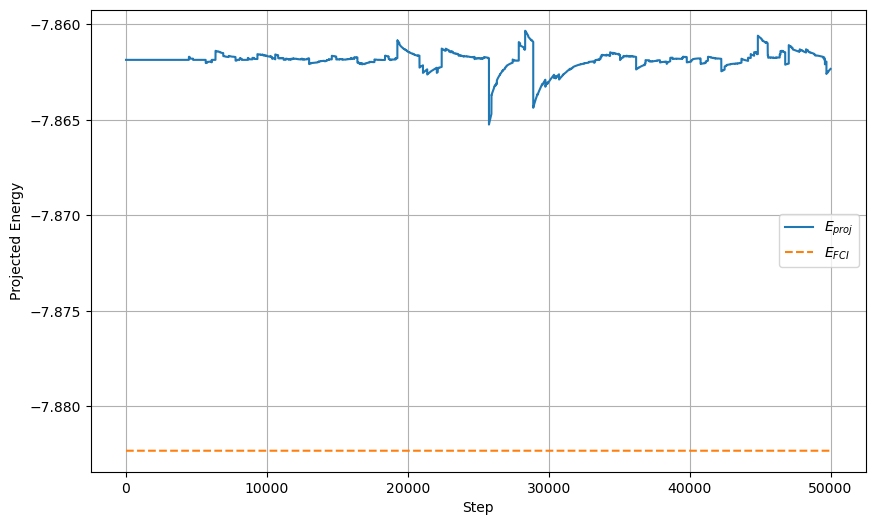

In [151]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    # basis="6-31g",
    # basis="6-31g(d)",
    # basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=50000, n_prod=20000, step_starting_shift_upd=20000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 6-31g(d,p)
FCI行列は?x?

--- K Matrix shape:(29241, 29241) ---
[[ 1.77635684e-15 -8.13150965e-08 -8.36649967e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.13150965e-08  1.49183480e-01 -3.73250995e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.36649967e-09 -3.73250995e-03  2.21133798e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.59440770e+01
   7.42439937e-18 -3.68253891e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.42439937e-18
   1.72874354e+01  5.26243800e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -3.68253891e-17
   5.26243800e-17  1.73991629e+01]]


  2%|▋                                            | 607/40000 [00:00<00:06, 6066.06it/s, E_proj=-7.981176, n_walkwers=1, shift=0.70000]

  1 walkers on 0th determinant


  3%|█▎                                          | 1214/40000 [00:00<00:10, 3582.63it/s, E_proj=-8.084695, n_walkwers=2, shift=0.70000]

  1 walkers on 0th determinant
  -1 walkers on 18060th determinant


  5%|██▎                                         | 2133/40000 [00:01<00:27, 1397.32it/s, E_proj=-8.023448, n_walkwers=8, shift=0.70000]

  2 walkers on 0th determinant
  1 walkers on 17991th determinant
  -1 walkers on 6156th determinant
  -1 walkers on 105th determinant
  -1 walkers on 6192th determinant
  -1 walkers on 6441th determinant
  -1 walkers on 22188th determinant


  8%|███▎                                        | 3032/40000 [00:02<01:21, 452.26it/s, E_proj=-8.020990, n_walkwers=21, shift=0.70000]

  -4 walkers on 6156th determinant
  3 walkers on 0th determinant
  1 walkers on 17956th determinant
  -1 walkers on 3636th determinant
  1 walkers on 7723th determinant
  -1 walkers on 18060th determinant
  1 walkers on 1th determinant
  -1 walkers on 105th determinant
  -1 walkers on 1710th determinant
  1 walkers on 15597th determinant
  ... more


 10%|████▍                                       | 4030/40000 [00:07<03:36, 166.05it/s, E_proj=-7.967615, n_walkwers=60, shift=0.70000]

  7 walkers on 0th determinant
  -5 walkers on 6156th determinant
  3 walkers on 1th determinant
  2 walkers on 36th determinant
  2 walkers on 91th determinant
  2 walkers on 17965th determinant
  -2 walkers on 15666th determinant
  1 walkers on 9408th determinant
  1 walkers on 20640th determinant
  -1 walkers on 3636th determinant
  ... more


 13%|█████▌                                      | 5015/40000 [00:15<05:32, 105.16it/s, E_proj=-7.982803, n_walkwers=96, shift=0.70000]

  13 walkers on 0th determinant
  -6 walkers on 6156th determinant
  5 walkers on 1th determinant
  3 walkers on 17956th determinant
  3 walkers on 91th determinant
  3 walkers on 6166th determinant
  2 walkers on 181th determinant
  2 walkers on 10th determinant
  -2 walkers on 7698th determinant
  -2 walkers on 1710th determinant
  ... more


 15%|██████▌                                     | 6015/40000 [00:27<07:40, 73.79it/s, E_proj=-7.998365, n_walkwers=190, shift=0.70000]

  37 walkers on 0th determinant
  10 walkers on 1th determinant
  -8 walkers on 6156th determinant
  -4 walkers on 15th determinant
  -4 walkers on 1710th determinant
  3 walkers on 17956th determinant
  3 walkers on 10th determinant
  3 walkers on 91th determinant
  -3 walkers on 15597th determinant
  -3 walkers on 23392th determinant
  ... more


 18%|███████▋                                    | 7011/40000 [00:41<09:04, 60.64it/s, E_proj=-8.009674, n_walkwers=337, shift=0.70000]

  70 walkers on 0th determinant
  16 walkers on 1th determinant
  -14 walkers on 6156th determinant
  -11 walkers on 1710th determinant
  -9 walkers on 15652th determinant
  -7 walkers on 20640th determinant
  -6 walkers on 23392th determinant
  -5 walkers on 15th determinant
  -5 walkers on 6157th determinant
  5 walkers on 171th determinant
  ... more


 20%|████████▊                                   | 8009/40000 [00:59<10:50, 49.16it/s, E_proj=-7.997187, n_walkwers=528, shift=0.70000]

  116 walkers on 0th determinant
  32 walkers on 1th determinant
  -20 walkers on 1710th determinant
  -17 walkers on 6156th determinant
  16 walkers on 10th determinant
  -10 walkers on 15th determinant
  -8 walkers on 6157th determinant
  -7 walkers on 172th determinant
  7 walkers on 1047th determinant
  -6 walkers on 6192th determinant
  ... more


 23%|█████████▋                                 | 9007/40000 [01:22<12:42, 40.65it/s, E_proj=-8.006074, n_walkwers=1031, shift=0.70000]

  247 walkers on 0th determinant
  61 walkers on 1th determinant
  -32 walkers on 1710th determinant
  -29 walkers on 6156th determinant
  27 walkers on 10th determinant
  20 walkers on 1815th determinant
  -17 walkers on 15th determinant
  -16 walkers on 172th determinant
  -16 walkers on 6192th determinant
  -16 walkers on 6157th determinant
  ... more


 25%|██████████▌                               | 10005/40000 [01:50<15:39, 31.94it/s, E_proj=-8.013558, n_walkwers=2093, shift=0.70000]

  561 walkers on 0th determinant
  109 walkers on 1th determinant
  43 walkers on 10th determinant
  -42 walkers on 6156th determinant
  -41 walkers on 1720th determinant
  -38 walkers on 26316th determinant
  -32 walkers on 6192th determinant
  -32 walkers on 1710th determinant
  -28 walkers on 6157th determinant
  -27 walkers on 172th determinant
  ... more


 28%|███████████▌                              | 11004/40000 [02:26<19:14, 25.12it/s, E_proj=-8.005172, n_walkwers=3392, shift=0.46069]

  1018 walkers on 0th determinant
  174 walkers on 1th determinant
  -93 walkers on 1720th determinant
  64 walkers on 10th determinant
  -55 walkers on 9460th determinant
  -54 walkers on 26254th determinant
  -54 walkers on 6192th determinant
  -49 walkers on 172th determinant
  -47 walkers on 1710th determinant
  -45 walkers on 1711th determinant
  ... more


 30%|████████████▌                             | 12003/40000 [03:08<20:15, 23.04it/s, E_proj=-8.001447, n_walkwers=4630, shift=0.26186]

  1481 walkers on 0th determinant
  225 walkers on 1th determinant
  -149 walkers on 1720th determinant
  -98 walkers on 6157th determinant
  -85 walkers on 7740th determinant
  78 walkers on 17965th determinant
  71 walkers on 10th determinant
  -69 walkers on 1711th determinant
  -65 walkers on 26254th determinant
  -52 walkers on 1032th determinant
  ... more


 33%|█████████████▋                            | 13004/40000 [03:54<22:49, 19.71it/s, E_proj=-8.010075, n_walkwers=6075, shift=0.19154]

  1903 walkers on 0th determinant
  259 walkers on 1th determinant
  -212 walkers on 7740th determinant
  163 walkers on 1815th determinant
  160 walkers on 6261th determinant
  -148 walkers on 26316th determinant
  -95 walkers on 6157th determinant
  93 walkers on 10th determinant
  -92 walkers on 20565th determinant
  -92 walkers on 1720th determinant
  ... more


 35%|██████████████▋                           | 14004/40000 [04:43<21:40, 19.98it/s, E_proj=-8.003380, n_walkwers=6969, shift=0.18837]

  2285 walkers on 0th determinant
  320 walkers on 1th determinant
  -308 walkers on 1720th determinant
  -198 walkers on 6157th determinant
  -154 walkers on 6192th determinant
  86 walkers on 17965th determinant
  77 walkers on 10th determinant
  -75 walkers on 9460th determinant
  -68 walkers on 1710th determinant
  -67 walkers on 9411th determinant
  ... more


 38%|███████████████▊                          | 15004/40000 [05:39<24:02, 17.33it/s, E_proj=-8.008646, n_walkwers=8897, shift=0.13553]

  2902 walkers on 0th determinant
  -577 walkers on 6192th determinant
  414 walkers on 1th determinant
  -210 walkers on 1711th determinant
  -185 walkers on 1720th determinant
  -177 walkers on 6157th determinant
  -146 walkers on 558th determinant
  -132 walkers on 23392th determinant
  -131 walkers on 1746th determinant
  -125 walkers on 172th determinant
  ... more


 40%|████████████████▍                        | 16004/40000 [06:38<23:43, 16.85it/s, E_proj=-8.023435, n_walkwers=10330, shift=0.00080]

  3094 walkers on 0th determinant
  422 walkers on 1th determinant
  -318 walkers on 18060th determinant
  -308 walkers on 26316th determinant
  -297 walkers on 6192th determinant
  -256 walkers on 1711th determinant
  -215 walkers on 6157th determinant
  -194 walkers on 7740th determinant
  151 walkers on 1815th determinant
  149 walkers on 17956th determinant
  ... more


 43%|█████████████████▊                        | 17004/40000 [07:37<21:27, 17.86it/s, E_proj=-7.997656, n_walkwers=9127, shift=0.10793]

  3436 walkers on 0th determinant
  413 walkers on 1th determinant
  -181 walkers on 1711th determinant
  -160 walkers on 6157th determinant
  -154 walkers on 9460th determinant
  -148 walkers on 172th determinant
  116 walkers on 36th determinant
  113 walkers on 17956th determinant
  -104 walkers on 1746th determinant
  -104 walkers on 207th determinant
  ... more


 45%|██████████████████▍                      | 18004/40000 [08:36<23:08, 15.84it/s, E_proj=-8.017052, n_walkwers=12085, shift=0.18558]

  4138 walkers on 0th determinant
  -602 walkers on 18060th determinant
  450 walkers on 1th determinant
  -283 walkers on 6192th determinant
  201 walkers on 17965th determinant
  -181 walkers on 1720th determinant
  174 walkers on 17991th determinant
  -167 walkers on 7698th determinant
  -152 walkers on 6157th determinant
  142 walkers on 36th determinant
  ... more


 48%|███████████████████▍                     | 19002/40000 [09:45<26:15, 13.32it/s, E_proj=-8.002976, n_walkwers=15405, shift=0.23839]

  5228 walkers on 0th determinant
  508 walkers on 1th determinant
  -420 walkers on 207th determinant
  -380 walkers on 6157th determinant
  -347 walkers on 1720th determinant
  320 walkers on 17965th determinant
  -211 walkers on 7815th determinant
  -196 walkers on 6192th determinant
  -193 walkers on 1032th determinant
  -191 walkers on 172th determinant
  ... more


 50%|████████████████████▌                    | 20002/40000 [11:02<25:46, 12.93it/s, E_proj=-7.997807, n_walkwers=17047, shift=0.22725]

  6606 walkers on 0th determinant
  595 walkers on 1th determinant
  -367 walkers on 1711th determinant
  -360 walkers on 207th determinant
  -283 walkers on 1720th determinant
  -277 walkers on 9460th determinant
  -261 walkers on 6157th determinant
  -221 walkers on 15714th determinant
  -209 walkers on 26316th determinant
  -209 walkers on 4843th determinant
  ... more


 53%|█████████████████████▌                   | 21002/40000 [12:20<24:34, 12.89it/s, E_proj=-8.012449, n_walkwers=20200, shift=0.17546]

  7332 walkers on 0th determinant
  -974 walkers on 23392th determinant
  675 walkers on 1th determinant
  -399 walkers on 26316th determinant
  -370 walkers on 7740th determinant
  -352 walkers on 1720th determinant
  -338 walkers on 1711th determinant
  321 walkers on 1815th determinant
  -311 walkers on 9541th determinant
  279 walkers on 6261th determinant
  ... more


 55%|██████████████████████▌                  | 22002/40000 [13:45<26:40, 11.25it/s, E_proj=-8.016275, n_walkwers=26882, shift=0.23952]

  9638 walkers on 0th determinant
  -1442 walkers on 18060th determinant
  810 walkers on 1th determinant
  782 walkers on 17965th determinant
  -587 walkers on 1720th determinant
  -502 walkers on 6166th determinant
  -445 walkers on 1711th determinant
  441 walkers on 1815th determinant
  -400 walkers on 26254th determinant
  -379 walkers on 1746th determinant
  ... more


 58%|███████████████████████▌                 | 23002/40000 [15:22<28:48,  9.83it/s, E_proj=-8.001217, n_walkwers=32300, shift=0.24068]

  12357 walkers on 0th determinant
  880 walkers on 1th determinant
  767 walkers on 17956th determinant
  -751 walkers on 1711th determinant
  -698 walkers on 181th determinant
  -483 walkers on 1720th determinant
  479 walkers on 17991th determinant
  -456 walkers on 9460th determinant
  -390 walkers on 7815th determinant
  -352 walkers on 172th determinant
  ... more


 60%|████████████████████████▌                | 24002/40000 [17:17<33:53,  7.87it/s, E_proj=-8.006800, n_walkwers=44753, shift=0.21034]

  16518 walkers on 0th determinant
  1368 walkers on 17965th determinant
  -1239 walkers on 20565th determinant
  -1193 walkers on 7740th determinant
  -1181 walkers on 6192th determinant
  965 walkers on 1th determinant
  -857 walkers on 26316th determinant
  -831 walkers on 6157th determinant
  -740 walkers on 1711th determinant
  -630 walkers on 181th determinant
  ... more


 63%|█████████████████████████               | 25002/40000 [19:20<30:23,  8.23it/s, E_proj=-8.001376, n_walkwers=41614, shift=-0.23511]

  16237 walkers on 0th determinant
  -1100 walkers on 207th determinant
  -1032 walkers on 6157th determinant
  848 walkers on 1th determinant
  -786 walkers on 1711th determinant
  -698 walkers on 15652th determinant
  684 walkers on 6261th determinant
  -634 walkers on 181th determinant
  -531 walkers on 20640th determinant
  -511 walkers on 6192th determinant
  ... more


 65%|██████████████████████████              | 26002/40000 [21:07<25:38,  9.10it/s, E_proj=-8.007374, n_walkwers=32310, shift=-0.25434]

  11799 walkers on 0th determinant
  1083 walkers on 17991th determinant
  -910 walkers on 26316th determinant
  -804 walkers on 9460th determinant
  639 walkers on 1th determinant
  613 walkers on 6261th determinant
  -588 walkers on 6157th determinant
  -548 walkers on 1711th determinant
  -499 walkers on 4816th determinant
  -460 walkers on 181th determinant
  ... more


 68%|███████████████████████████             | 27003/40000 [22:43<21:12, 10.21it/s, E_proj=-8.023681, n_walkwers=30130, shift=-0.16350]

  9818 walkers on 0th determinant
  -1332 walkers on 18060th determinant
  -1194 walkers on 6192th determinant
  560 walkers on 1815th determinant
  -528 walkers on 26316th determinant
  -433 walkers on 6157th determinant
  425 walkers on 1th determinant
  -414 walkers on 26254th determinant
  -406 walkers on 9411th determinant
  -403 walkers on 7740th determinant
  ... more


 70%|████████████████████████████            | 28003/40000 [24:17<17:34, 11.38it/s, E_proj=-8.008104, n_walkwers=23265, shift=-0.20367]

  8513 walkers on 0th determinant
  -532 walkers on 18060th determinant
  -478 walkers on 6166th determinant
  -462 walkers on 181th determinant
  -403 walkers on 6192th determinant
  -383 walkers on 20640th determinant
  333 walkers on 1815th determinant
  327 walkers on 1th determinant
  -327 walkers on 207th determinant
  -284 walkers on 26254th determinant
  ... more


 73%|█████████████████████████████▋           | 29002/40000 [25:46<17:28, 10.49it/s, E_proj=-8.003461, n_walkwers=22804, shift=0.13277]

  8565 walkers on 0th determinant
  993 walkers on 17991th determinant
  -409 walkers on 172th determinant
  377 walkers on 6261th determinant
  -372 walkers on 9411th determinant
  -368 walkers on 9541th determinant
  -292 walkers on 15652th determinant
  -269 walkers on 181th determinant
  -269 walkers on 6166th determinant
  -267 walkers on 26254th determinant
  ... more


 75%|██████████████████████████████▊          | 30002/40000 [27:17<15:10, 10.99it/s, E_proj=-8.013777, n_walkwers=25438, shift=0.06224]

  9440 walkers on 0th determinant
  887 walkers on 17991th determinant
  -872 walkers on 18060th determinant
  -811 walkers on 6192th determinant
  -608 walkers on 15652th determinant
  -385 walkers on 181th determinant
  363 walkers on 6261th determinant
  355 walkers on 17956th determinant
  -329 walkers on 1720th determinant
  315 walkers on 36th determinant
  ... more


 78%|███████████████████████████████▊         | 31003/40000 [28:53<14:17, 10.49it/s, E_proj=-8.002491, n_walkwers=26026, shift=0.07115]

  9858 walkers on 0th determinant
  671 walkers on 17965th determinant
  -653 walkers on 6192th determinant
  -497 walkers on 6157th determinant
  -497 walkers on 1720th determinant
  -326 walkers on 3612th determinant
  -325 walkers on 15714th determinant
  -320 walkers on 26316th determinant
  311 walkers on 6247th determinant
  -271 walkers on 181th determinant
  ... more


 80%|████████████████████████████████▊        | 32002/40000 [30:26<12:41, 10.50it/s, E_proj=-8.003628, n_walkwers=29053, shift=0.17902]

  11457 walkers on 0th determinant
  -781 walkers on 1746th determinant
  -663 walkers on 6192th determinant
  -566 walkers on 181th determinant
  -476 walkers on 23392th determinant
  -464 walkers on 6157th determinant
  -434 walkers on 4843th determinant
  -426 walkers on 172th determinant
  -423 walkers on 20640th determinant
  -423 walkers on 9433th determinant
  ... more


 83%|█████████████████████████████████▊       | 33002/40000 [32:04<12:20,  9.45it/s, E_proj=-8.005431, n_walkwers=37093, shift=0.24160]

  13853 walkers on 0th determinant
  -968 walkers on 1746th determinant
  927 walkers on 17991th determinant
  -785 walkers on 6192th determinant
  -745 walkers on 7740th determinant
  630 walkers on 276th determinant
  -622 walkers on 6157th determinant
  -488 walkers on 172th determinant
  457 walkers on 1th determinant
  453 walkers on 17956th determinant
  ... more


 85%|██████████████████████████████████▊      | 34002/40000 [33:51<11:01,  9.07it/s, E_proj=-7.996688, n_walkwers=40124, shift=0.02908]

  15795 walkers on 0th determinant
  -866 walkers on 15652th determinant
  -864 walkers on 207th determinant
  -849 walkers on 181th determinant
  -591 walkers on 1746th determinant
  -553 walkers on 1711th determinant
  538 walkers on 1th determinant
  -422 walkers on 172th determinant
  412 walkers on 171th determinant
  399 walkers on 17956th determinant
  ... more


 88%|███████████████████████████████████▉     | 35002/40000 [35:41<08:59,  9.26it/s, E_proj=-7.995538, n_walkwers=38406, shift=0.11415]

  16677 walkers on 0th determinant
  -862 walkers on 181th determinant
  806 walkers on 276th determinant
  -641 walkers on 9541th determinant
  -636 walkers on 1746th determinant
  -596 walkers on 207th determinant
  -563 walkers on 1711th determinant
  554 walkers on 1th determinant
  -509 walkers on 15714th determinant
  -477 walkers on 4816th determinant
  ... more


 90%|████████████████████████████████████▉    | 36002/40000 [37:35<08:08,  8.19it/s, E_proj=-8.007103, n_walkwers=50324, shift=0.21575]

  19892 walkers on 0th determinant
  -2170 walkers on 26316th determinant
  1570 walkers on 6261th determinant
  1104 walkers on 17965th determinant
  966 walkers on 276th determinant
  -939 walkers on 6157th determinant
  -869 walkers on 181th determinant
  -763 walkers on 1746th determinant
  -746 walkers on 6166th determinant
  -688 walkers on 9411th determinant
  ... more


 93%|█████████████████████████████████████▉   | 37002/40000 [39:41<07:04,  7.07it/s, E_proj=-7.998830, n_walkwers=60529, shift=0.15775]

  24180 walkers on 0th determinant
  -1718 walkers on 9541th determinant
  -1676 walkers on 7740th determinant
  -1553 walkers on 6157th determinant
  1204 walkers on 17991th determinant
  -1190 walkers on 1720th determinant
  -993 walkers on 172th determinant
  -867 walkers on 1032th determinant
  -772 walkers on 181th determinant
  746 walkers on 276th determinant
  ... more


 95%|██████████████████████████████████████▉  | 38002/40000 [41:59<04:55,  6.77it/s, E_proj=-8.008056, n_walkwers=78751, shift=0.18508]

  28925 walkers on 0th determinant
  -3135 walkers on 7740th determinant
  2118 walkers on 17965th determinant
  -1952 walkers on 15652th determinant
  -1752 walkers on 1720th determinant
  -1610 walkers on 1746th determinant
  -1400 walkers on 172th determinant
  -1111 walkers on 6157th determinant
  -926 walkers on 20565th determinant
  -870 walkers on 18060th determinant
  ... more


 98%|███████████████████████████████████████ | 39002/40000 [44:19<02:08,  7.75it/s, E_proj=-8.023640, n_walkwers=68808, shift=-0.50404]

  24243 walkers on 0th determinant
  -2555 walkers on 26316th determinant
  -1907 walkers on 18060th determinant
  -1756 walkers on 1746th determinant
  -1475 walkers on 23392th determinant
  -1342 walkers on 26254th determinant
  1276 walkers on 6261th determinant
  -1092 walkers on 7740th determinant
  -945 walkers on 4833th determinant
  -893 walkers on 4843th determinant
  ... more


100%|████████████████████████████████████████| 40000/40000 [46:24<00:00, 14.37it/s, E_proj=-8.023640, n_walkwers=68808, shift=-0.50404]



---- Walkers (result) ----
  18351 walkers on 0th determinant
  -1076 walkers on 26254th determinant
  -974 walkers on 1720th determinant
  -917 walkers on 1746th determinant
  840 walkers on 1815th determinant
  838 walkers on 17965th determinant
  -752 walkers on 15652th determinant
  -726 walkers on 6192th determinant
  -707 walkers on 20565th determinant
  -697 walkers on 558th determinant
  ... more
------------------------------
FCI Energy: -8.008671 Ha
Final FCIQMC Energy: -8.005765 ±  0.005373 Ha
Average shift: 0.045033 Ha => Energy: -7.936142617456491


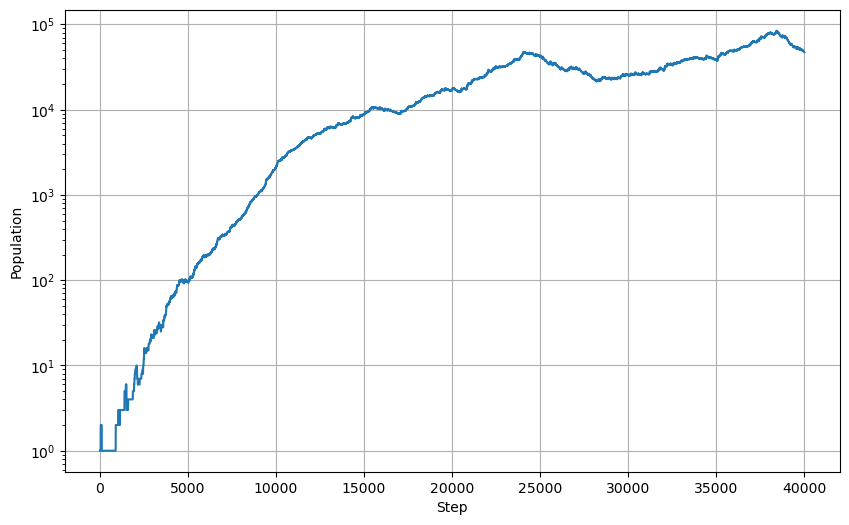

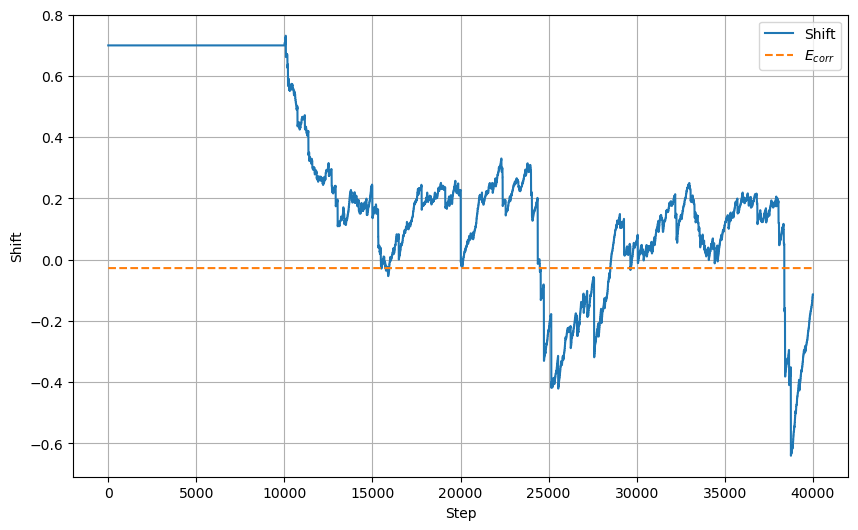

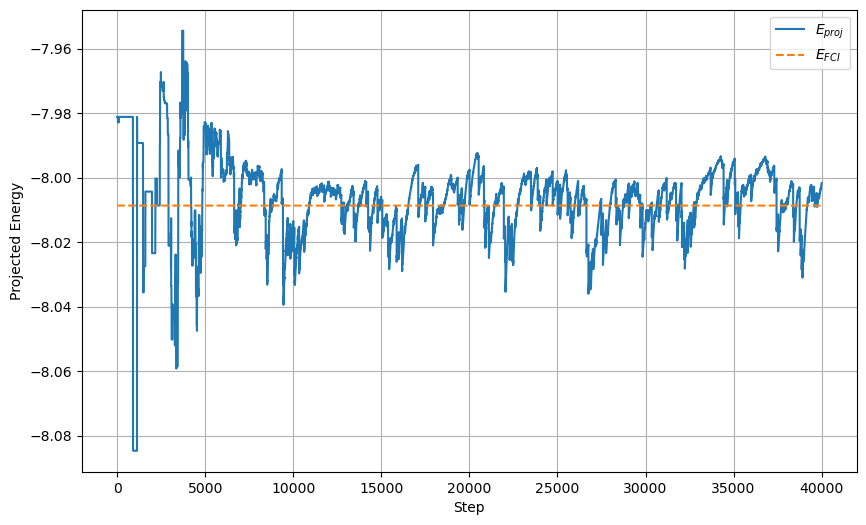

In [3]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="6-31g(d,p)",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=40000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 分子 STO-3G, ステップ数ごとの標準偏差の確認
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   1.50382491e-17  8.78436185e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50382491e-17
  -1.41526201e+00 -3.47698264e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.78436185e-18
  -3.47698264e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

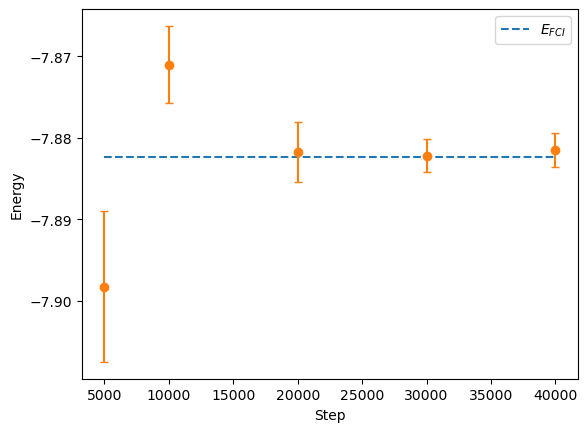

In [13]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## 外挿用（Det数:エネルギー）の共通関数を定義

In [5]:
def inverse_fit(N_det, E):
    x = 1.0 / N_det
    a, E_inf = np.polyfit(x, E, 1)
    fn = lambda N_det: a/N_det + E_inf    
    return a, E_inf, fn

def plot_extrapolation_to_inf_det(N_det, E, fn):    
    N_det_fit = np.linspace(N_det.min(), N_det.max(), 500)
    E_fit = fn(N_det_fit)

    plt.scatter(N_det, E, label="data")
    plt.plot(N_det_fit, E_fit, label=r"fit: $E_\infty + a/N$")
    plt.xlabel("Number of determinants")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

## ${H_2}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

Starting FCIQMC with the 6-31g basis set.


100%|████████████████████████████████████████| 20000/20000 [00:02<00:00, 8316.68it/s, E_proj=-1.152258, n_walkwers=1227, shift=0.00628]


Starting FCIQMC with the 6-31g(d) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:01<00:00, 10041.10it/s, E_proj=-1.148768, n_walkwers=46, shift=0.19949]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|████████████████████████████████████████| 20000/20000 [00:05<00:00, 3535.62it/s, E_proj=-1.180135, n_walkwers=205, shift=-0.25342]


Starting FCIQMC with the 6-311G(d,p) basis set.


100%|█████████████████████████████████████████| 20000/20000 [00:08<00:00, 2375.84it/s, E_proj=-1.170090, n_walkwers=372, shift=0.01239]


All FCIQMC calculations have completed.
E_inf: -1.169159172070451


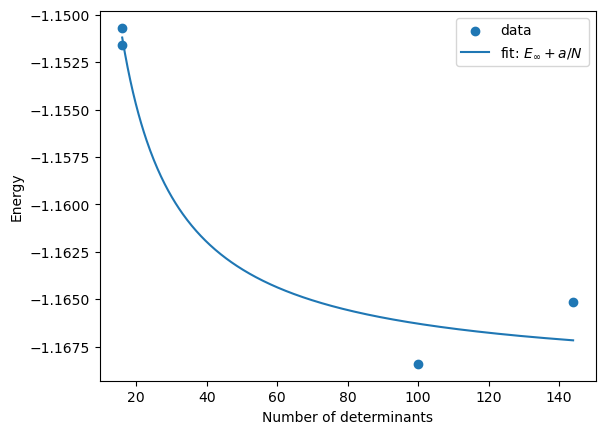

In [100]:
from pyscf import gto

# mol_1 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-31g(d,p)', verbose=0)
mol_5 = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='6-311G(d,p)', verbose=0)
mols = [mol_2, mol_3, mol_4, mol_5]

n_steps = 20000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

_, E_inf, fn = inverse_fit(N_det, E)
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)


## ${LiH}$ 分子 基底数vs.エネルギーで外挿して、真のEを値を推測する

In [4]:
from pyscf import gto

mol_1 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='sto-3g', verbose=0)
mol_2 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g', verbose=0)
mol_3 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d)', verbose=0)
mol_4 = gto.M(atom='Li 0 0 0; H 0 0 1.6', basis='6-31g(d,p)', verbose=0)
mols = [mol_1, mol_2, mol_3, mol_4]

n_steps = 40000
E = []
sd = []
N_det = np.zeros(len(mols))

for i, mol in enumerate(mols):
    print(f"Starting FCIQMC with the {mol.basis} basis set.")
    
    # determinantの数だけ欲しいが、molからは得られなかったので、
    # 冗長ではあるが、FCI Hamiltonianを生成して、行列の次元数を参照する
    H_mat, _, _ = build_hamiltonian(mol)

    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=3, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)
    N_det[i] = H_mat.shape[0]

print("All FCIQMC calculations have completed.")

Starting FCIQMC with the sto-3g basis set.


100%|███████████████████████████████████████| 40000/40000 [00:35<00:00, 1136.84it/s, E_proj=-7.880190, n_walkwers=9969, shift=-0.06585]


Starting FCIQMC with the 6-31g basis set.


100%|█████████████████████████████████████████| 40000/40000 [05:07<00:00, 130.04it/s, E_proj=-8.004459, n_walkwers=9421, shift=0.02323]


Starting FCIQMC with the 6-31g(d) basis set.


100%|████████████████████████████████████████| 40000/40000 [31:46<00:00, 20.98it/s, E_proj=-8.017295, n_walkwers=48951, shift=-0.04929]


Starting FCIQMC with the 6-31g(d,p) basis set.


100%|███████████████████████████████████████| 40000/40000 [1:27:23<00:00,  7.63it/s, E_proj=-8.008100, n_walkwers=94930, shift=0.10593]


All FCIQMC calculations have completed.


NameError: name 'inverse_fit' is not defined


Number of determinants: [  225.  3025. 14400. 29241.]
Energies: [np.float64(-7.8825610516142675), np.float64(-7.999504952870689), np.float64(-8.00476513085609), np.float64(-8.009363296702434)]
E_inf: -8.008650646649816


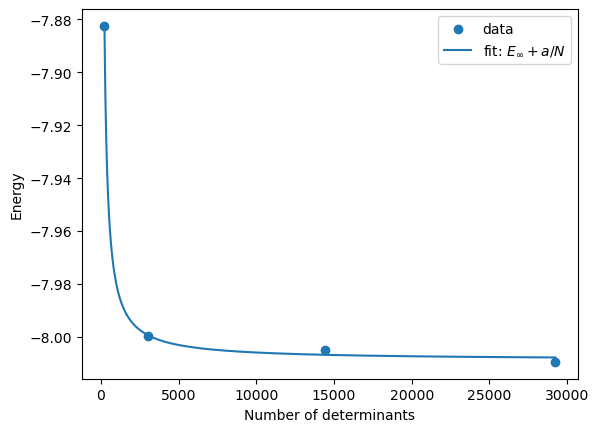

In [10]:
_, E_inf, fn = inverse_fit(N_det, E)

print(f"\nNumber of determinants: {N_det}")
print(f"Energies: {E}")
print(f"E_inf: {E_inf}")

plot_extrapolation_to_inf_det(N_det, E, fn)